In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, minmax_scale
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
Ravdess = '/kaggle/input/ravdess-emotional-speech-audio'

In [6]:
import re

Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12) - Female (as the actor ID number is even)

In [7]:
records = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/archive'):
    for filename in filenames:
        records.append([filename, os.path.join(dirname,filename)])

data = pd.DataFrame(records, columns=['filename','path'])
data['actor'] = data['path'].apply(lambda x: re.findall("\w+_\d+",x)[0])
data = data[data['actor']!="audio_speech_actors_01"]
data.reset_index(inplace=True,drop=True)
data['type'] = data['filename'].apply(lambda x: re.split("-\d+\.wav",x)[0])
data

filename  \
0     03-01-02-02-02-01-22.wav   
1     03-01-06-02-01-02-22.wav   
2     03-01-08-01-01-02-22.wav   
3     03-01-04-02-02-01-22.wav   
4     03-01-05-01-02-01-22.wav   
...                        ...   
1435  03-01-08-02-01-01-01.wav   
1436  03-01-06-01-01-02-01.wav   
1437  03-01-05-01-01-02-01.wav   
1438  03-01-06-01-02-01-01.wav   
1439  03-01-07-01-01-02-01.wav   

                                                   path     actor  \
0     /content/drive/MyDrive/archive/Actor_22/03-01-...  Actor_22   
1     /content/drive/MyDrive/archive/Actor_22/03-01-...  Actor_22   
2     /content/drive/MyDrive/archive/Actor_22/03-01-...  Actor_22   
3     /content/drive/MyDrive/archive/Actor_22/03-01-...  Actor_22   
4     /content/drive/MyDrive/archive/Actor_22/03-01-...  Actor_22   
...                                                 ...       ...   
1435  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   
1436  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   
1437  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   
1438  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   
1439  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   

                   type  
0     03-01-02-02-02-01  
1     03-01-06-02-01-02  
2     03-01-08-01-01-02  
3     03-01-04-02-02-01  
4     03-01-05-01-02-01  
...                 ...  
1435  03-01-08-02-01-01  
1436  03-01-06-01-01-02  
1437  03-01-05-01-01-02  
1438  03-01-06-01-02-01  
1439  03-01-07-01-01-02  

[1440 rows x 4 columns]

In [8]:
data['actor'].nunique()

24

In [9]:
data['actor'].value_counts()

Actor_22    60
Actor_20    60
Actor_02    60
Actor_04    60
Actor_03    60
Actor_05    60
Actor_14    60
Actor_07    60
Actor_08    60
Actor_09    60
Actor_06    60
Actor_10    60
Actor_13    60
Actor_12    60
Actor_11    60
Actor_15    60
Actor_17    60
Actor_19    60
Actor_16    60
Actor_23    60
Actor_24    60
Actor_21    60
Actor_18    60
Actor_01    60
Name: actor, dtype: int64

In [10]:
filter_list = []
for a in ["03","04"]:
    for b in ["01","02"]:
        for c in ["01","02"]:
            for d in ["01","02"]:
                filter_list.append(f"03-01-{a}-{b}-{c}-{d}")

data = data[data['type'].isin(filter_list)]
data.reset_index(inplace=True,drop=True)
data['class'] = data['type'].apply(lambda x: 'happy' if x.startswith('03-01-03') else 'sad')
data['gender'] = data['actor'].apply(lambda x: 'female' if int(x.split('_')[1])%2==0 else 'male')

<ipython-input-10-5f14ba484cdc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = data['type'].apply(lambda x: 'happy' if x.startswith('03-01-03') else 'sad')
<ipython-input-10-5f14ba484cdc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gender'] = data['actor'].apply(lambda x: 'female' if int(x.split('_')[1])%2==0 else 'male')


In [11]:
data

filename  \
0    03-01-04-02-02-01-22.wav   
1    03-01-03-02-01-01-22.wav   
2    03-01-03-02-01-02-22.wav   
3    03-01-04-02-01-01-22.wav   
4    03-01-04-01-01-01-22.wav   
..                        ...   
379  03-01-04-02-02-01-01.wav   
380  03-01-04-01-01-02-01.wav   
381  03-01-04-01-02-02-01.wav   
382  03-01-04-01-02-01-01.wav   
383  03-01-04-02-02-02-01.wav   

                                                  path     actor  \
0    /content/drive/MyDrive/archive/Actor_22/03-01-...  Actor_22   
1    /content/drive/MyDrive/archive/Actor_22/03-01-...  Actor_22   
2    /content/drive/MyDrive/archive/Actor_22/03-01-...  Actor_22   
3    /content/drive/MyDrive/archive/Actor_22/03-01-...  Actor_22   
4    /content/drive/MyDrive/archive/Actor_22/03-01-...  Actor_22   
..                                                 ...       ...   
379  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   
380  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   
381  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   
382  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   
383  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   

                  type  class  gender  
0    03-01-04-02-02-01    sad  female  
1    03-01-03-02-01-01  happy  female  
2    03-01-03-02-01-02  happy  female  
3    03-01-04-02-01-01    sad  female  
4    03-01-04-01-01-01    sad  female  
..                 ...    ...     ...  
379  03-01-04-02-02-01    sad    male  
380  03-01-04-01-01-02    sad    male  
381  03-01-04-01-02-02    sad    male  
382  03-01-04-01-02-01    sad    male  
383  03-01-04-02-02-02    sad    male  

[384 rows x 6 columns]

In [12]:
data['gender'].value_counts()

female    192
male      192
Name: gender, dtype: int64

In [13]:
data.loc[1,'filename'] in filter_list

False

In [36]:
def show_waveplot(audio_path,name,label,gender):
    x , sr = librosa.load(audio_path)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: {name}, Class: {label}, Gender: {gender}")

def show_spectrogram(audio_path,name,label,gender):
    x , sr = librosa.load(audio_path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram: {name}, Class: {label}, Gender: {gender}")

def show_zcr(audio_path,name,label,gender):
    x , sr = librosa.load(audio_path)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title(f'Zero Crossing Rate: {name}, Class: {label}, Gender: {gender}')
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,name,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Centroids: {name}, Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(y=x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.show()

def show_spectral_rolloff(audio_path,name,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Rolloff: {name}, Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.01)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(y=x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.show()

def show_mfccs(audio_path,name,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC: {name}, Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

In [15]:
happy =  data[data['class']=='happy'].sample(3)
happy

filename  \
176  03-01-03-01-01-02-12.wav   
201  03-01-03-02-01-02-13.wav   
151  03-01-03-02-02-01-15.wav   

                                                  path     actor  \
176  /content/drive/MyDrive/archive/Actor_12/03-01-...  Actor_12   
201  /content/drive/MyDrive/archive/Actor_13/03-01-...  Actor_13   
151  /content/drive/MyDrive/archive/Actor_15/03-01-...  Actor_15   

                  type  class  gender  
176  03-01-03-01-01-02  happy  female  
201  03-01-03-02-01-02  happy    male  
151  03-01-03-02-02-01  happy    male

In [16]:
sad = data[data['class']=='sad'].sample(3)
sad

filename  \
203  03-01-04-02-01-01-13.wav   
278  03-01-04-02-02-02-07.wav   
381  03-01-04-01-02-02-01.wav   

                                                  path     actor  \
203  /content/drive/MyDrive/archive/Actor_13/03-01-...  Actor_13   
278  /content/drive/MyDrive/archive/Actor_07/03-01-...  Actor_07   
381  /content/drive/MyDrive/archive/Actor_01/03-01-...  Actor_01   

                  type class gender  
203  03-01-04-02-01-01   sad   male  
278  03-01-04-02-02-02   sad   male  
381  03-01-04-01-02-02   sad   male

In [17]:
import IPython.display as ipd

## Happy

In [18]:
ipd.Audio(happy.iloc[0].path)

In [19]:
ipd.Audio(happy.iloc[1].path)

In [20]:
ipd.Audio(happy.iloc[2].path)

## Sad

In [21]:
ipd.Audio(sad.iloc[0].path)

In [22]:
ipd.Audio(sad.iloc[1].path)

In [23]:
ipd.Audio(sad.iloc[2].path)

## WavePlot

### happy

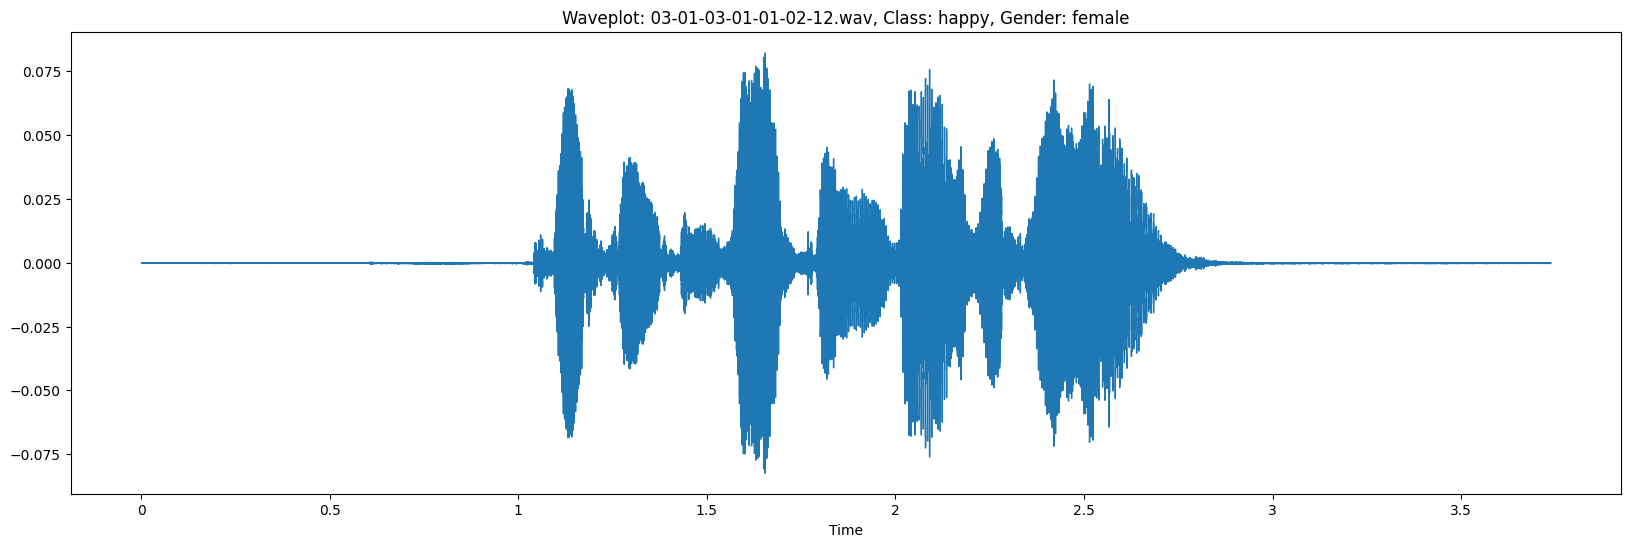

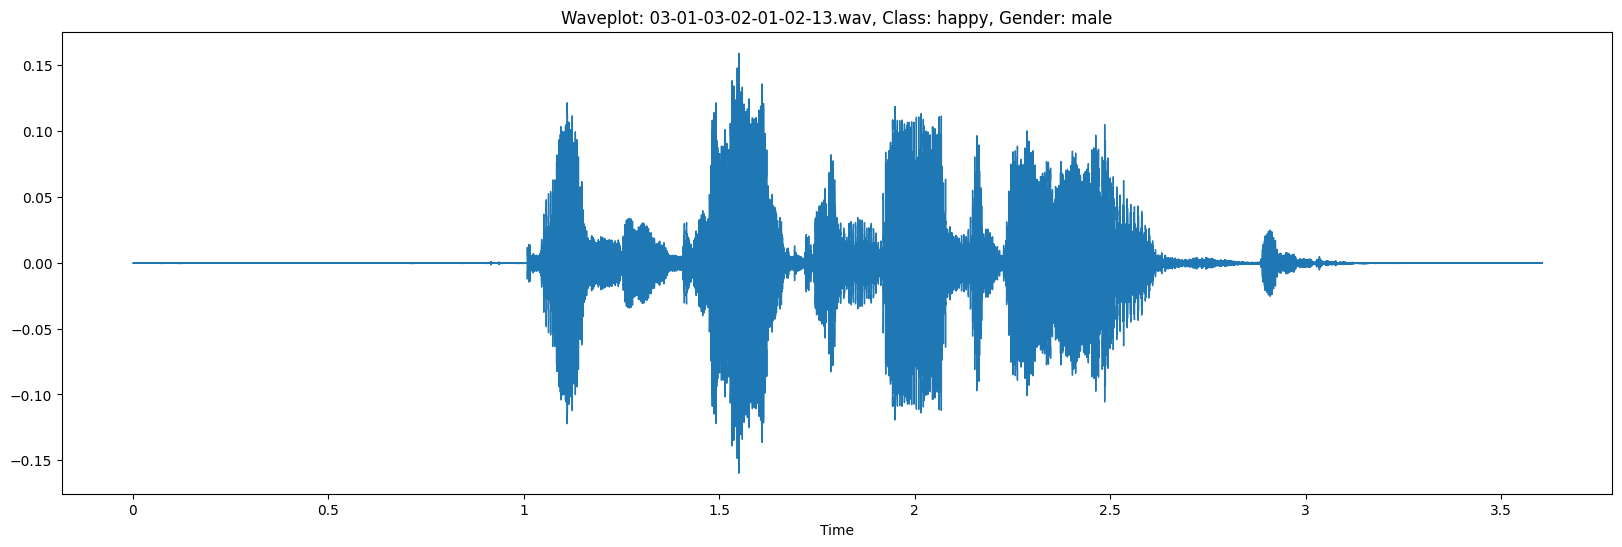

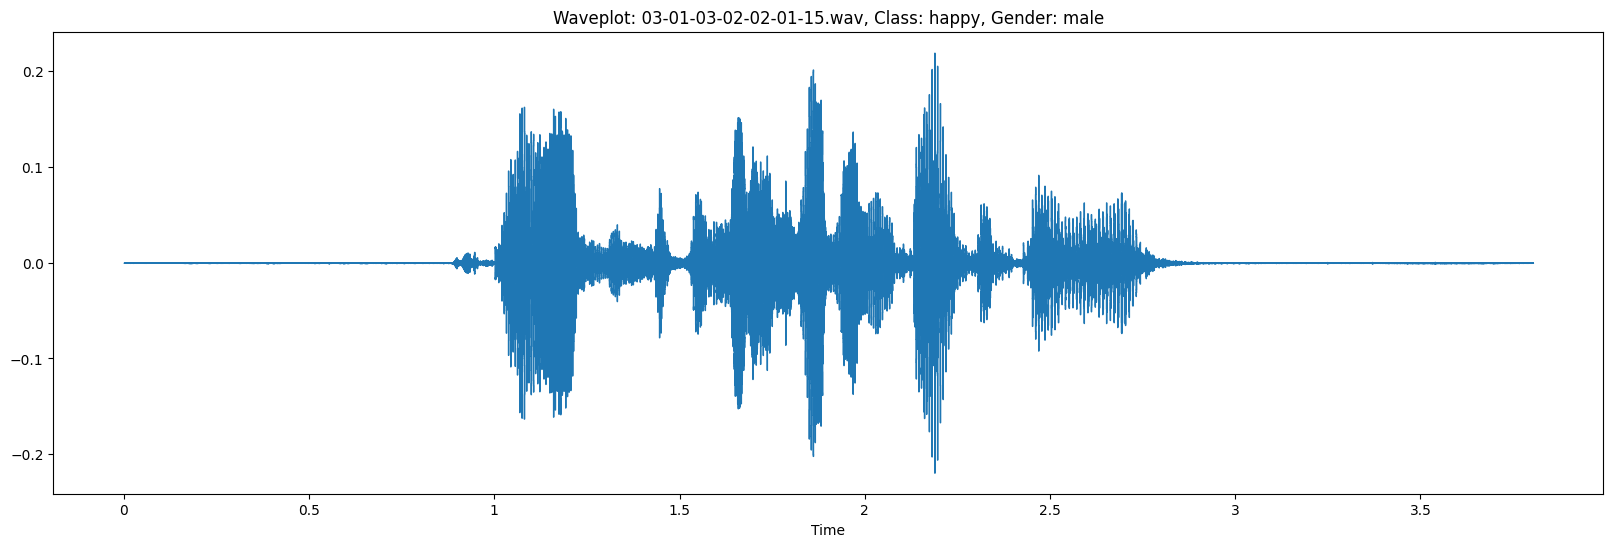

In [24]:
show_waveplot(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_waveplot(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_waveplot(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

### Sad

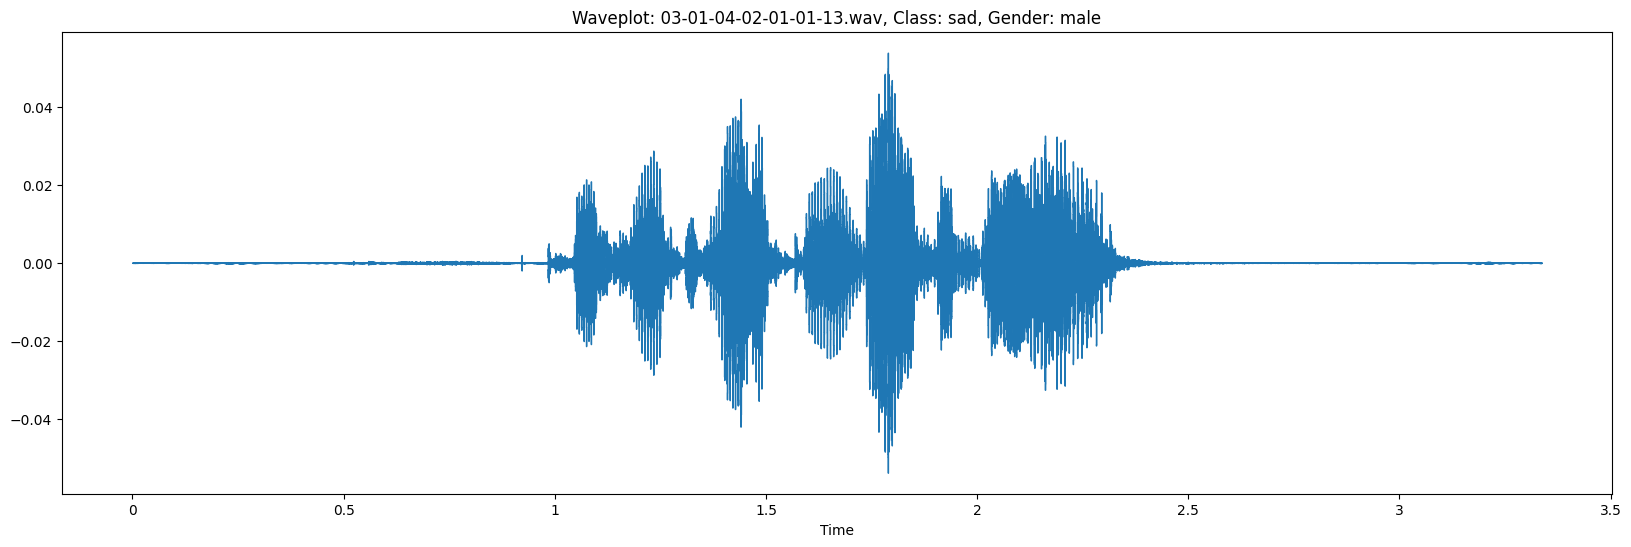

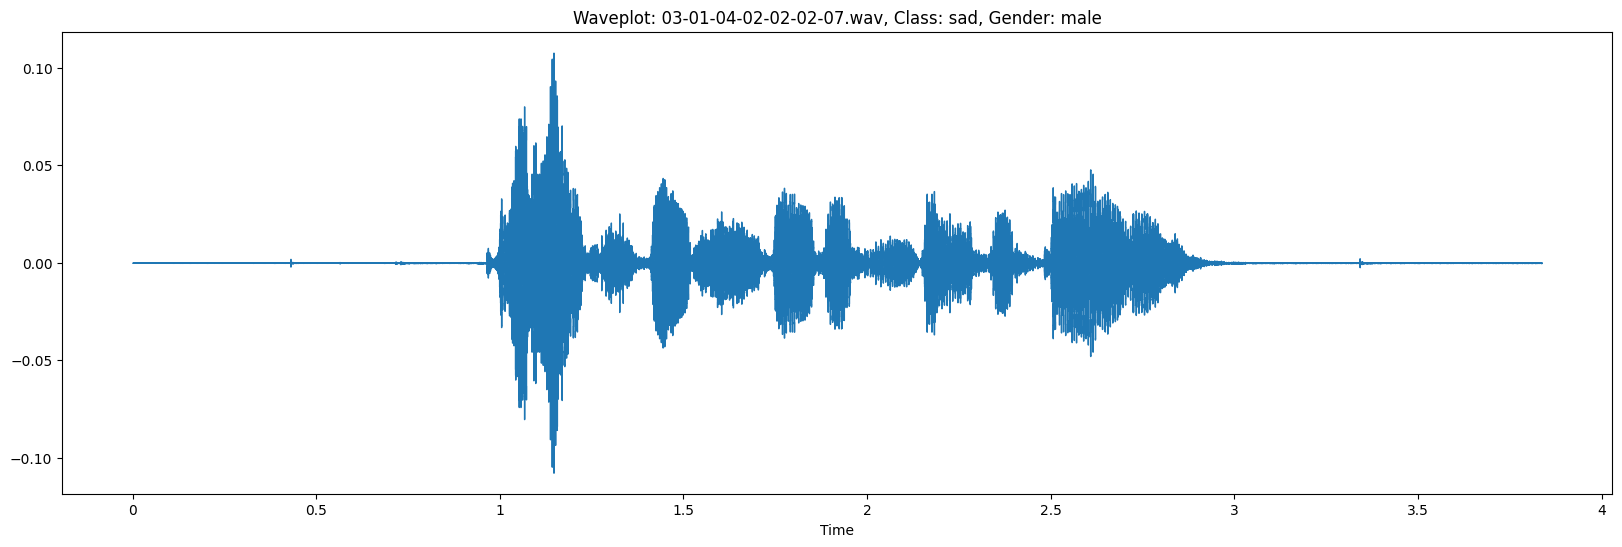

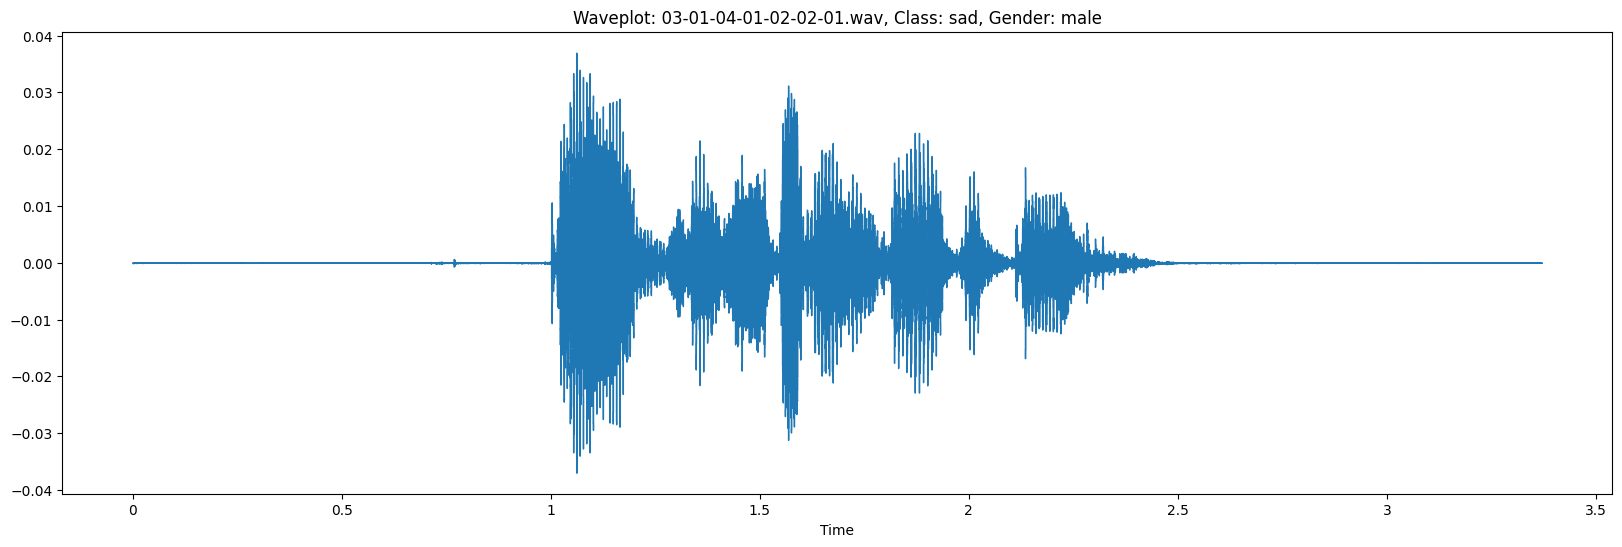

In [25]:
show_waveplot(sad.iloc[0].path,sad.iloc[0].filename,'sad',sad.iloc[0].gender)
show_waveplot(sad.iloc[1].path,sad.iloc[1].filename,'sad',sad.iloc[1].gender)
show_waveplot(sad.iloc[2].path,sad.iloc[2].filename,'sad',sad.iloc[2].gender)

## Spectrogram Happy

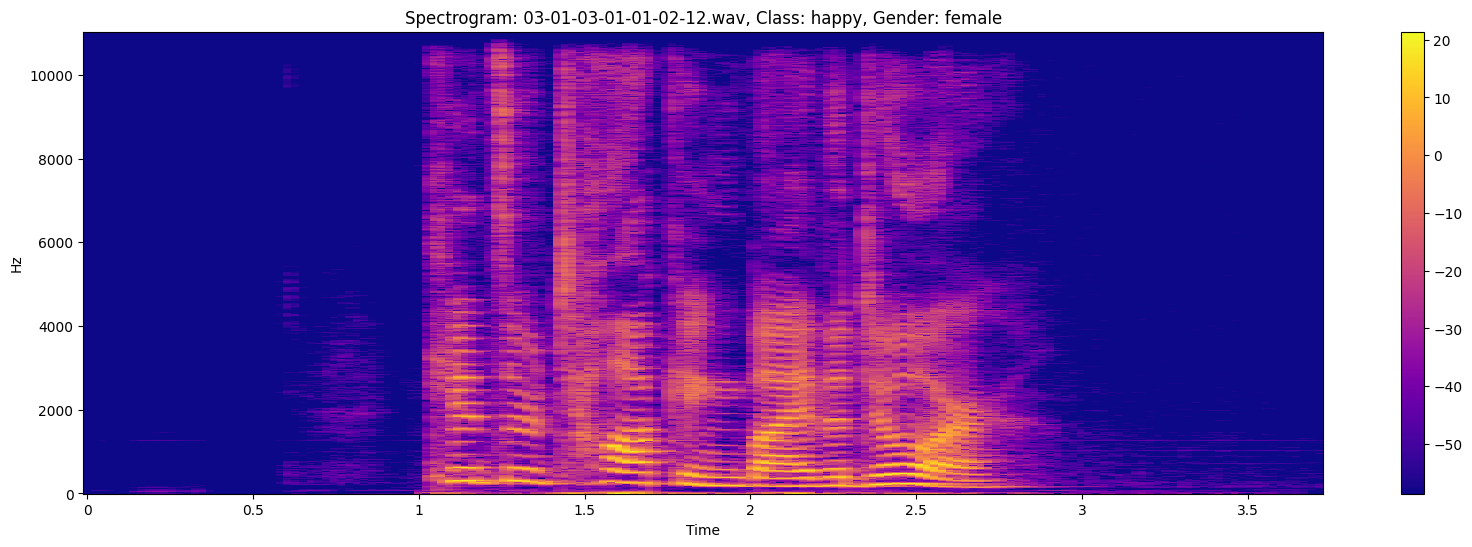

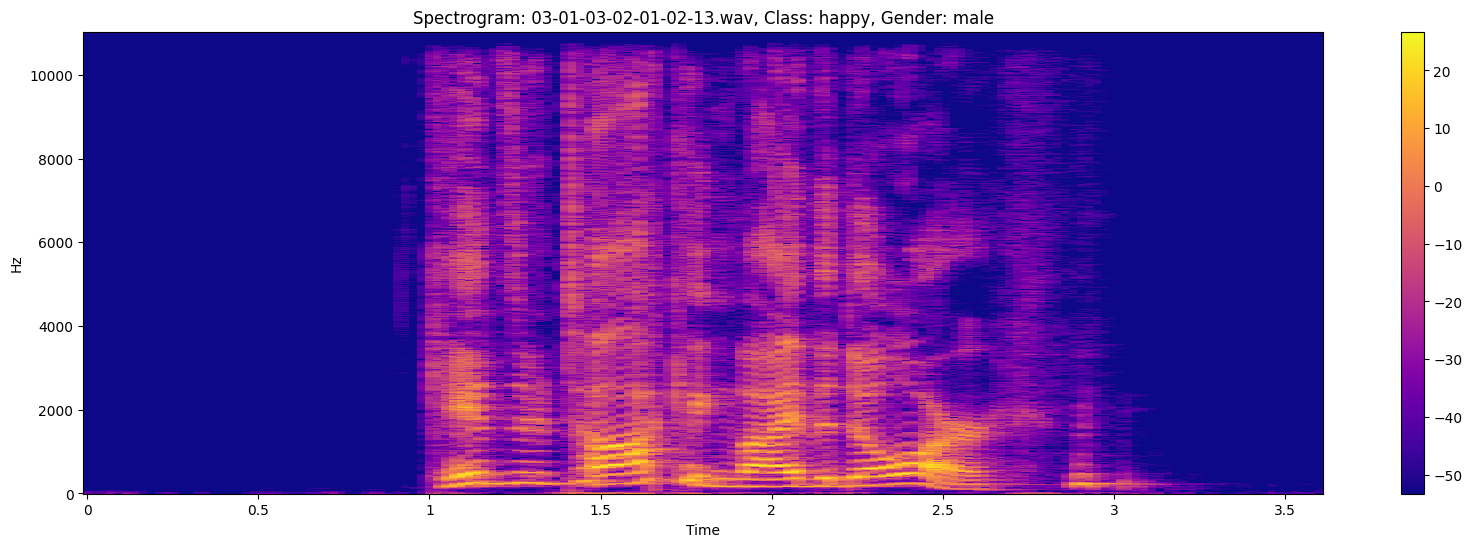

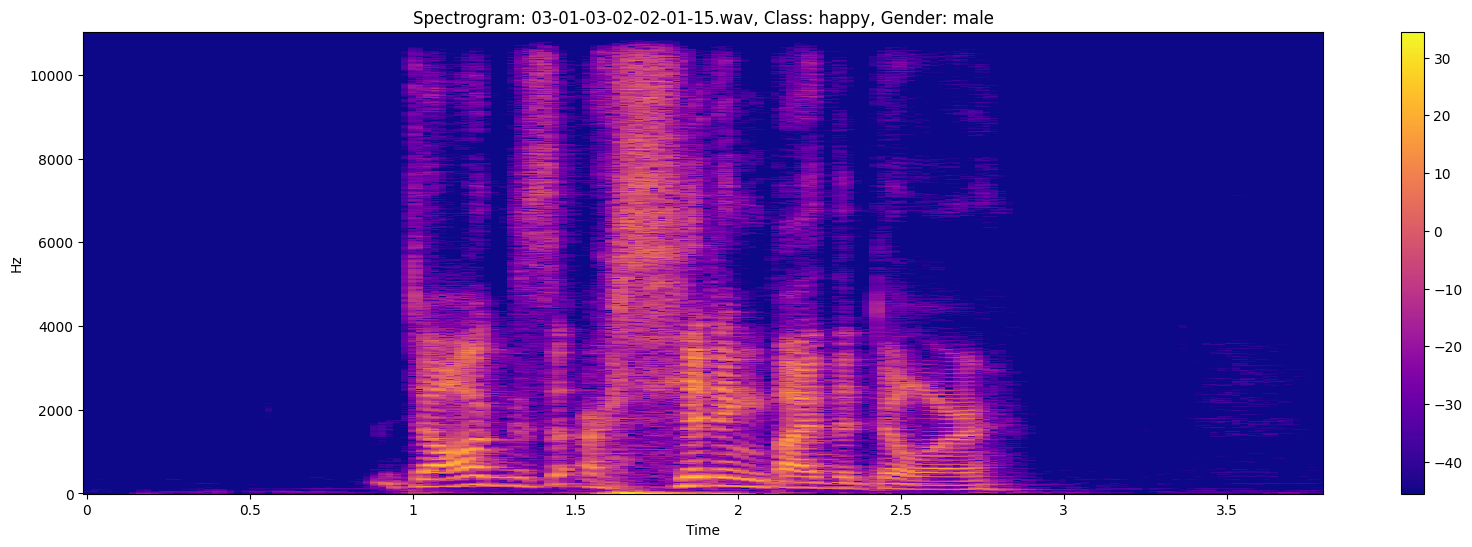

In [26]:
show_spectrogram(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_spectrogram(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_spectrogram(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

## Spectrogram - Sad

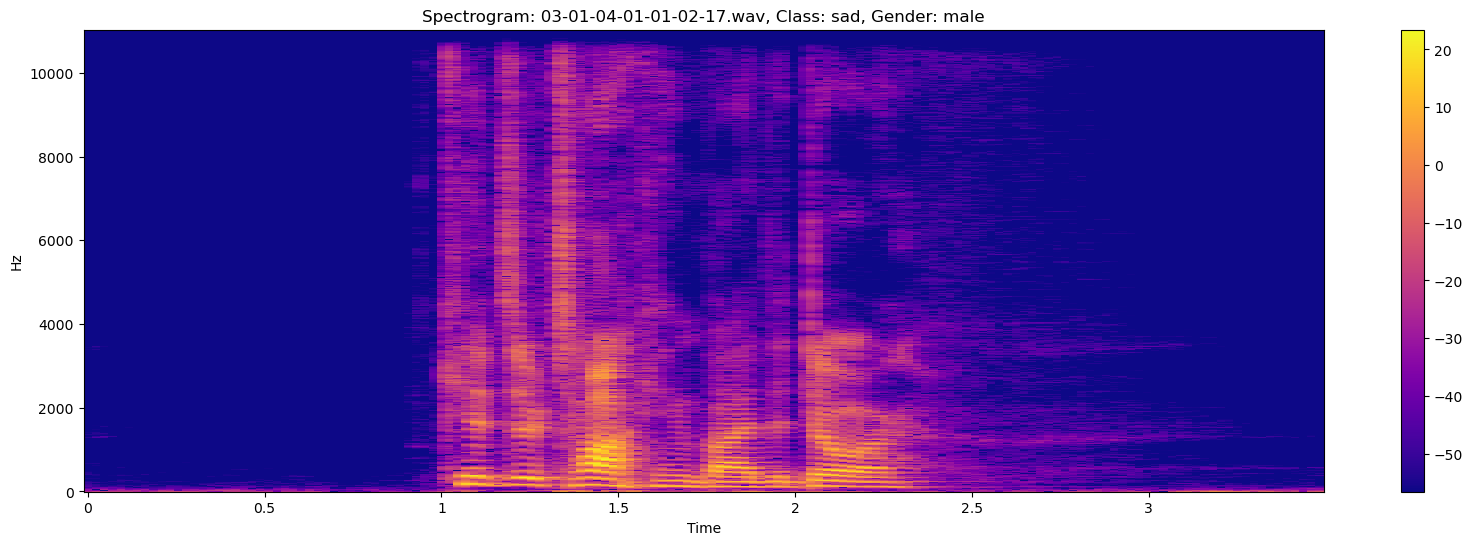

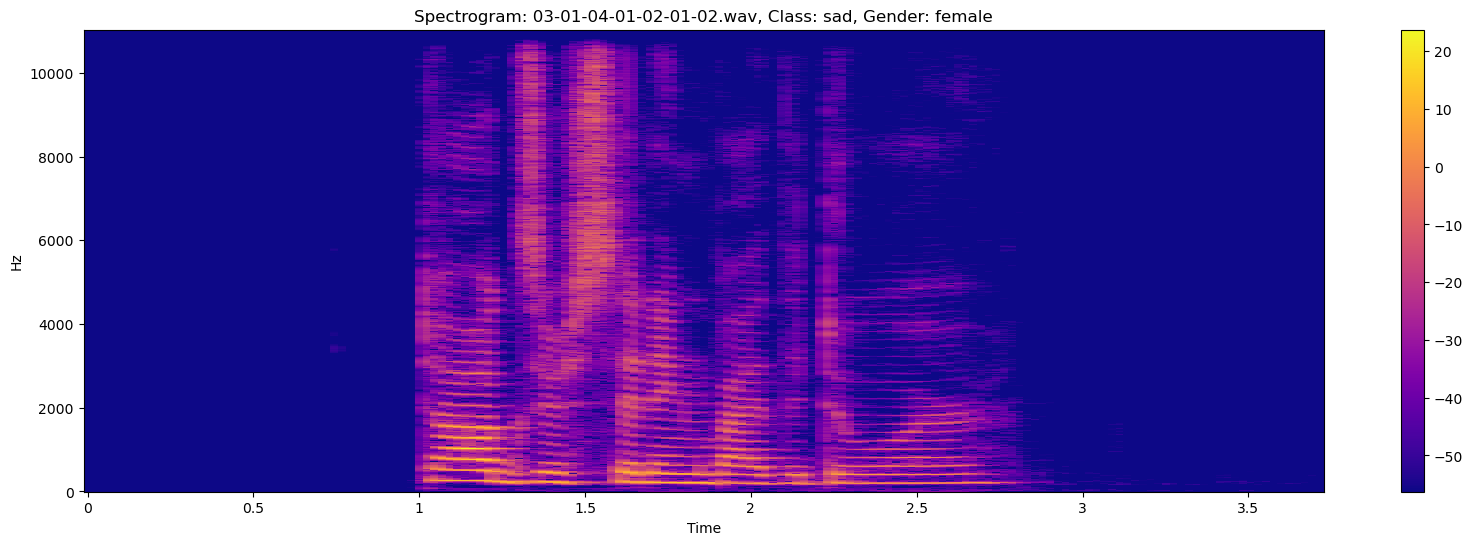

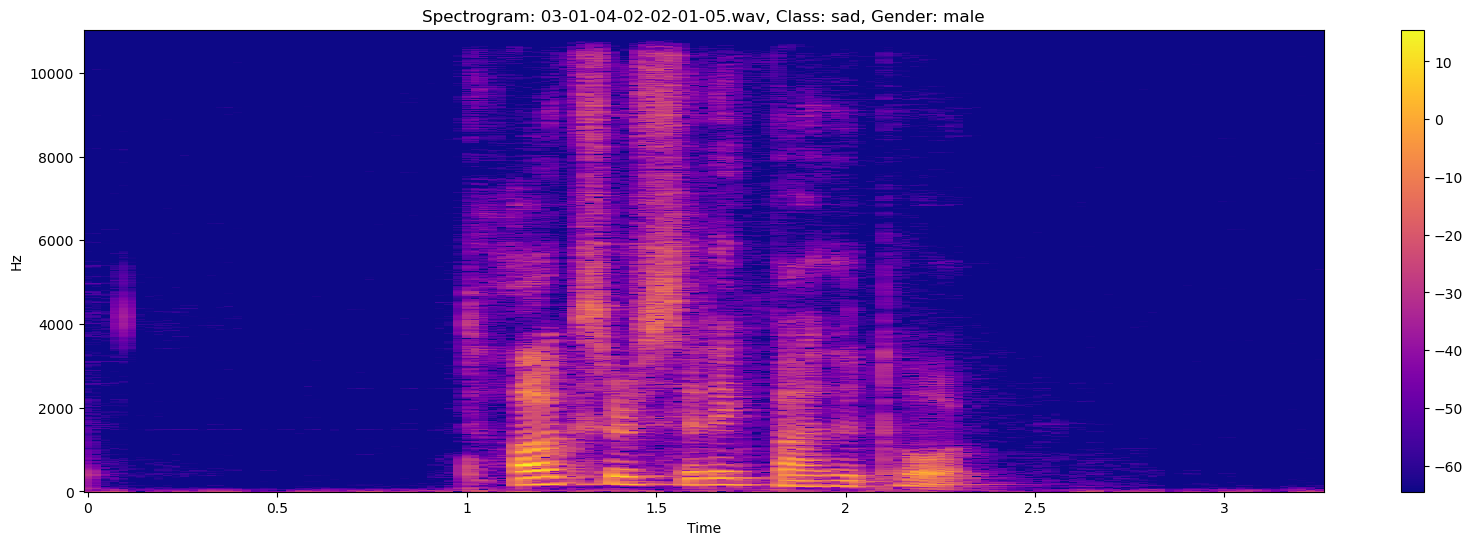

In [ ]:
show_spectrogram(sad.iloc[0].path,sad.iloc[0].filename,'sad',sad.iloc[0].gender)
show_spectrogram(sad.iloc[1].path,sad.iloc[1].filename,'sad',sad.iloc[1].gender)
show_spectrogram(sad.iloc[2].path,sad.iloc[2].filename,'sad',sad.iloc[2].gender)

## ZCR - HAPPY

Sum of zero crossing  13917


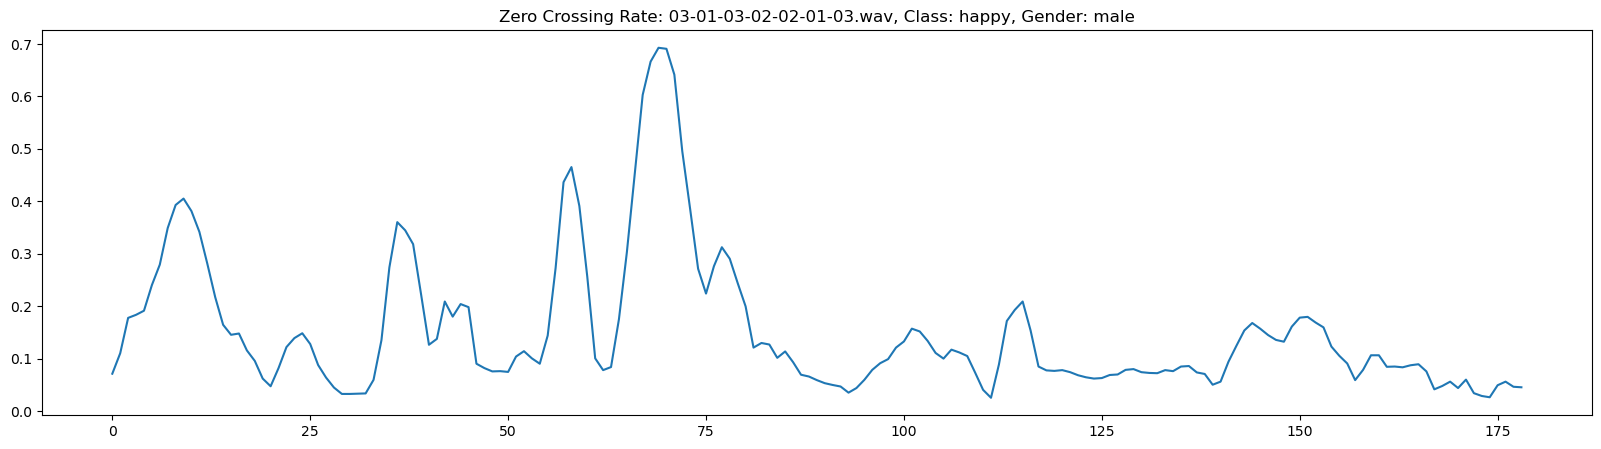

Sum of zero crossing  21531


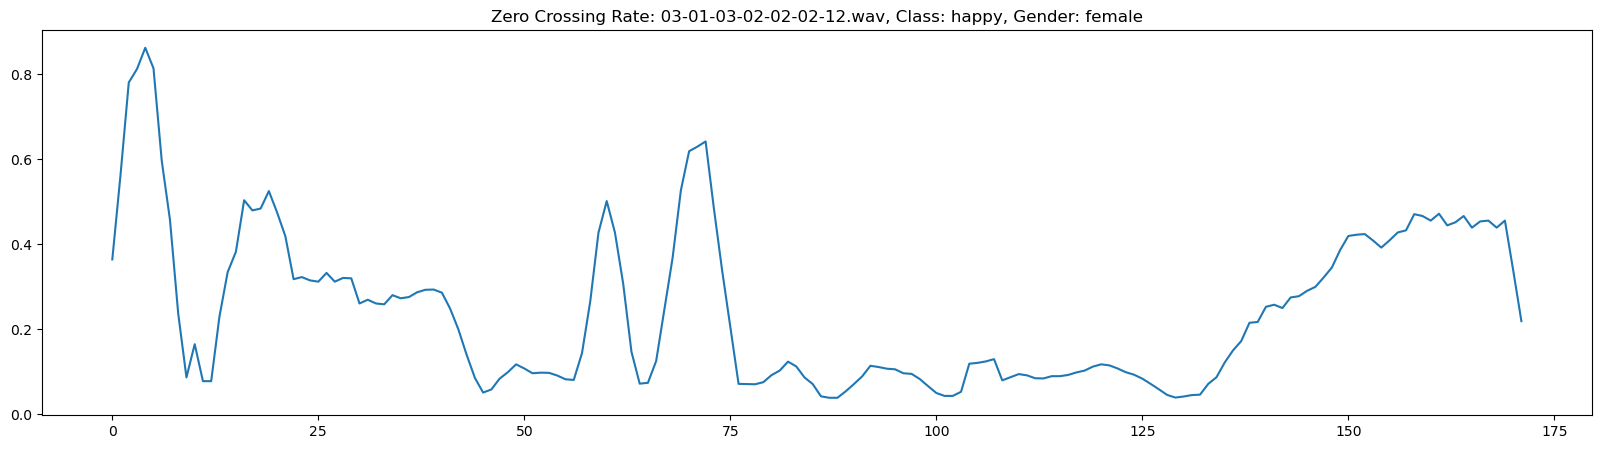

Sum of zero crossing  22119


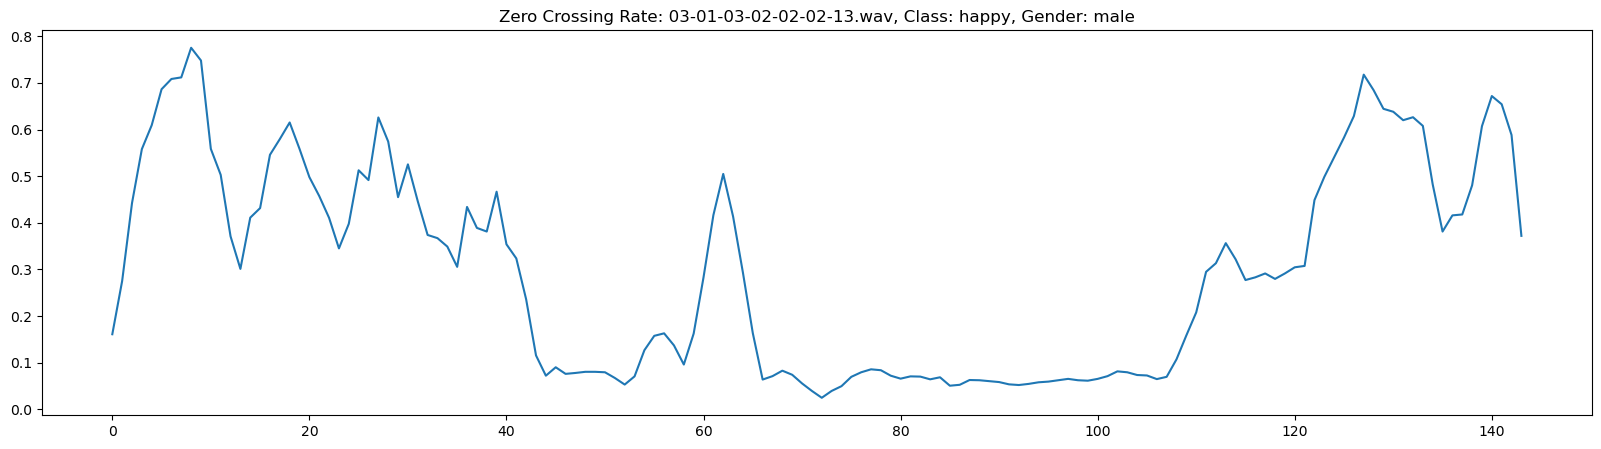

In [ ]:
show_zcr(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_zcr(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_zcr(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

## ZCR - SAD

Sum of zero crossing  9364


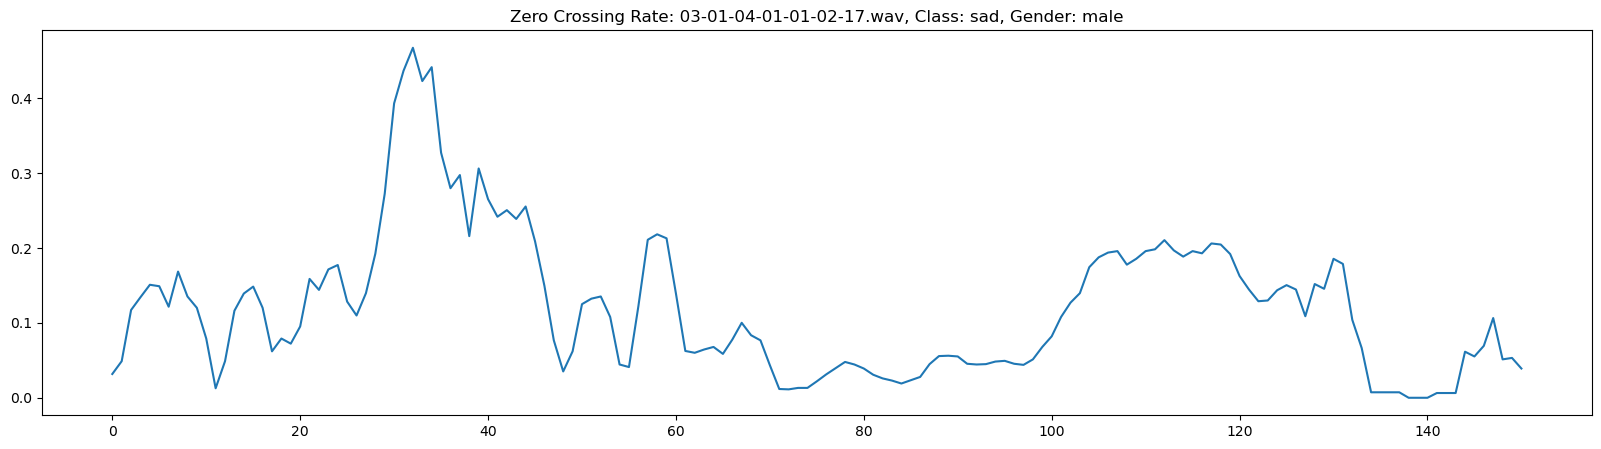

Sum of zero crossing  21433


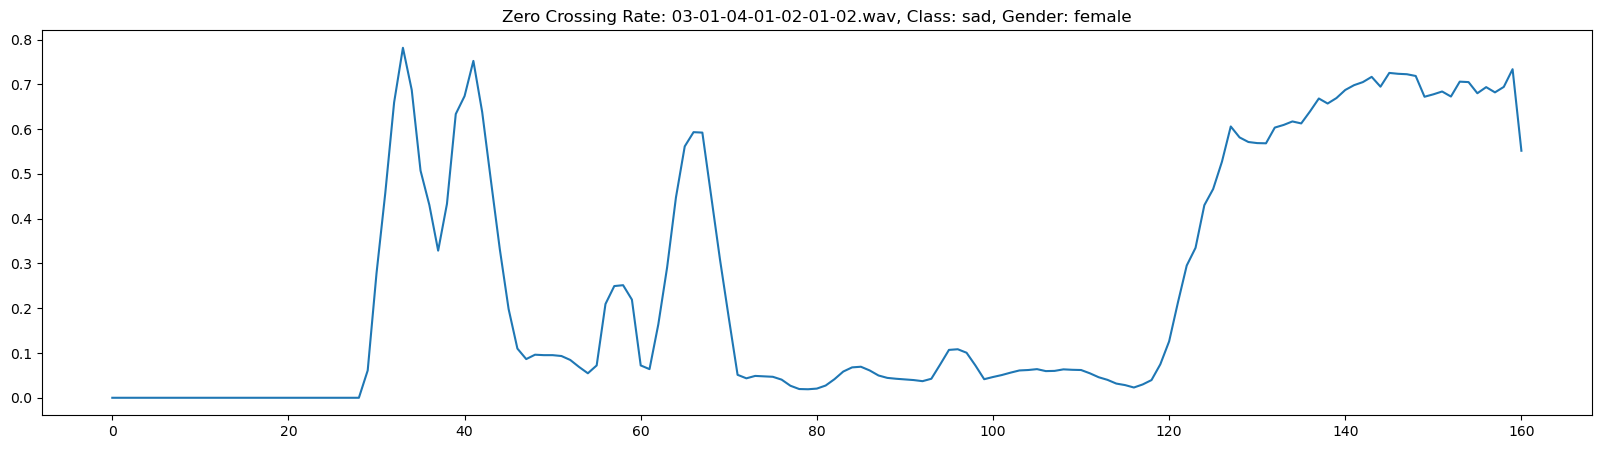

Sum of zero crossing  15765


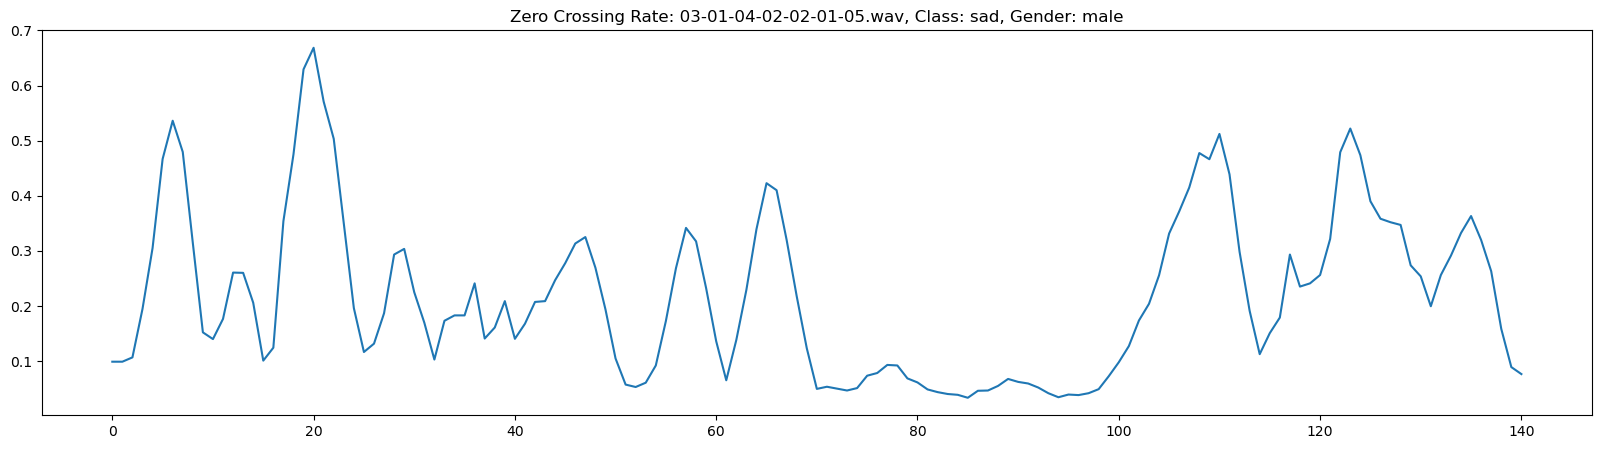

In [ ]:
show_zcr(sad.iloc[0].path,sad.iloc[0].filename,'sad',sad.iloc[0].gender)
show_zcr(sad.iloc[1].path,sad.iloc[1].filename,'sad',sad.iloc[1].gender)
show_zcr(sad.iloc[2].path,sad.iloc[2].filename,'sad',sad.iloc[2].gender)

## Spectral centroid - Happy

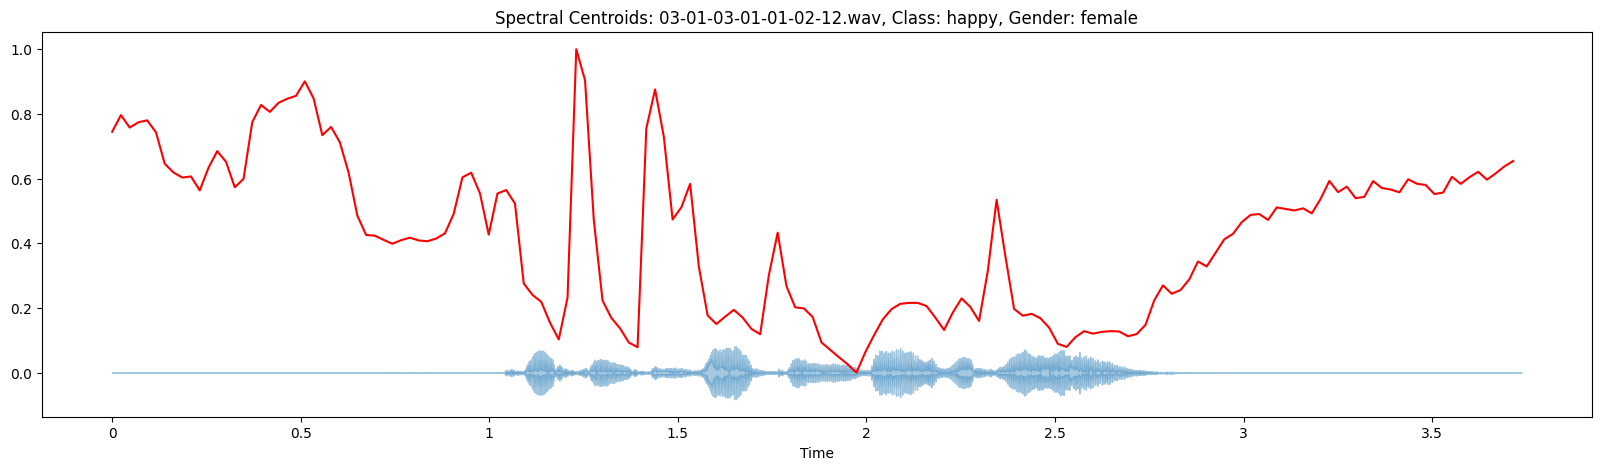

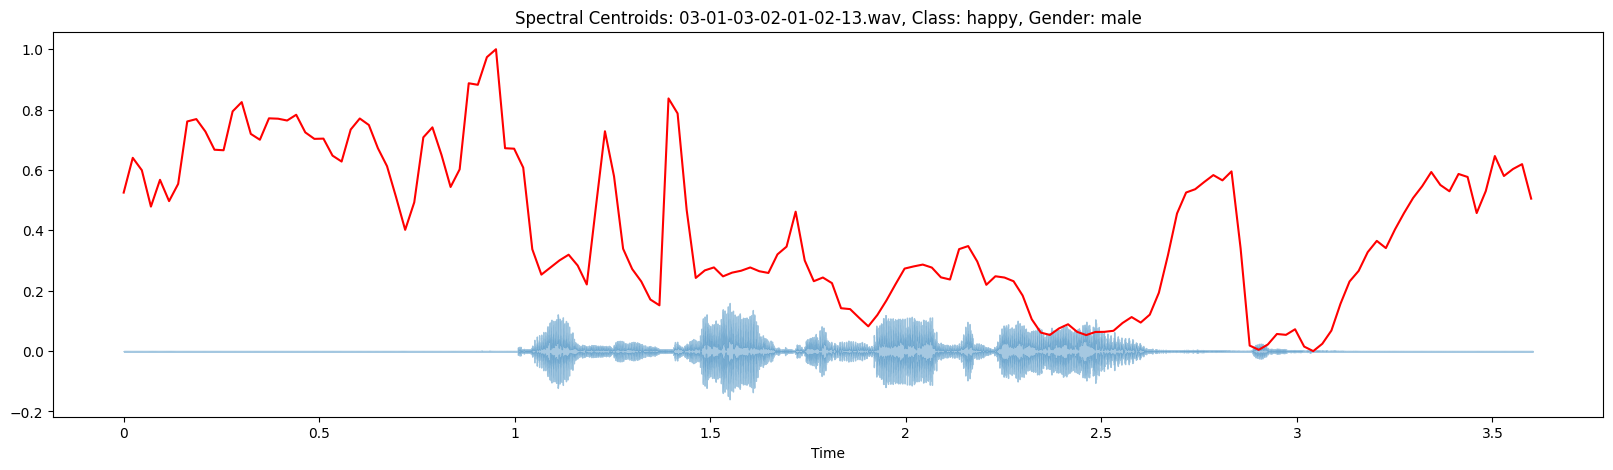

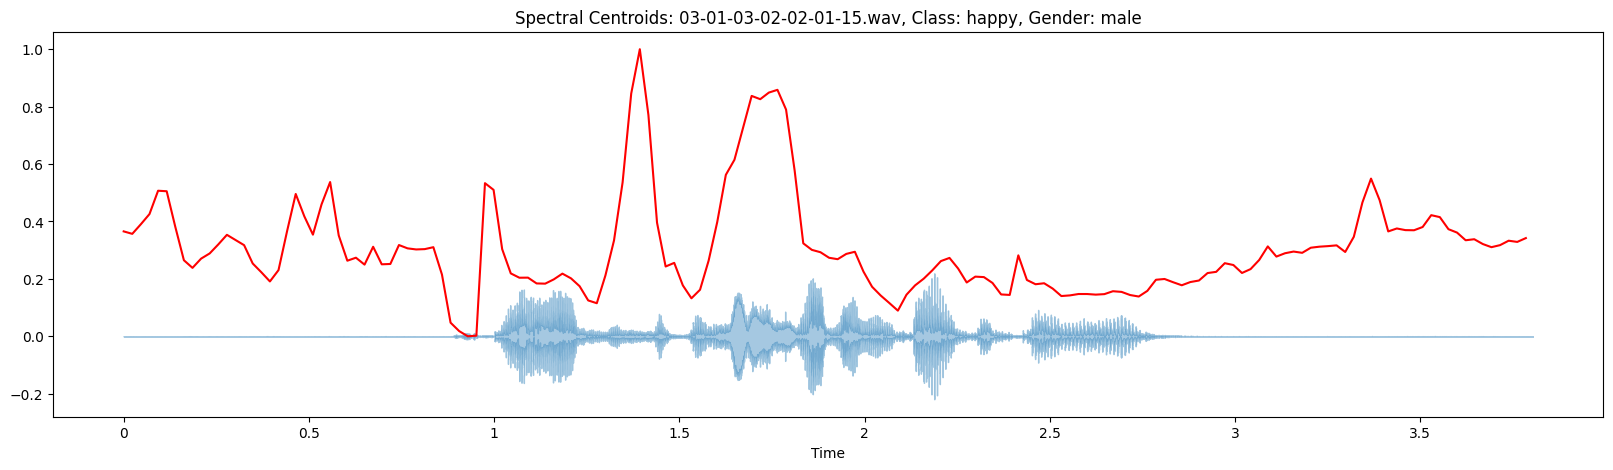

In [35]:
show_spectral_centroids(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_spectral_centroids(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_spectral_centroids(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

## Spectrak Rolloff

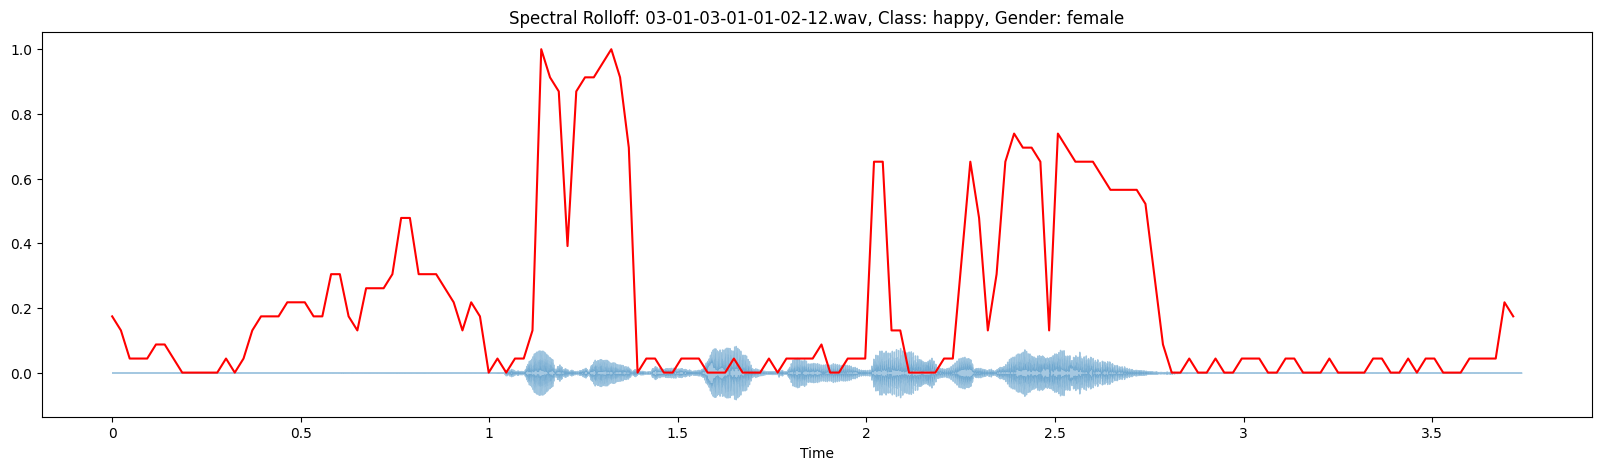

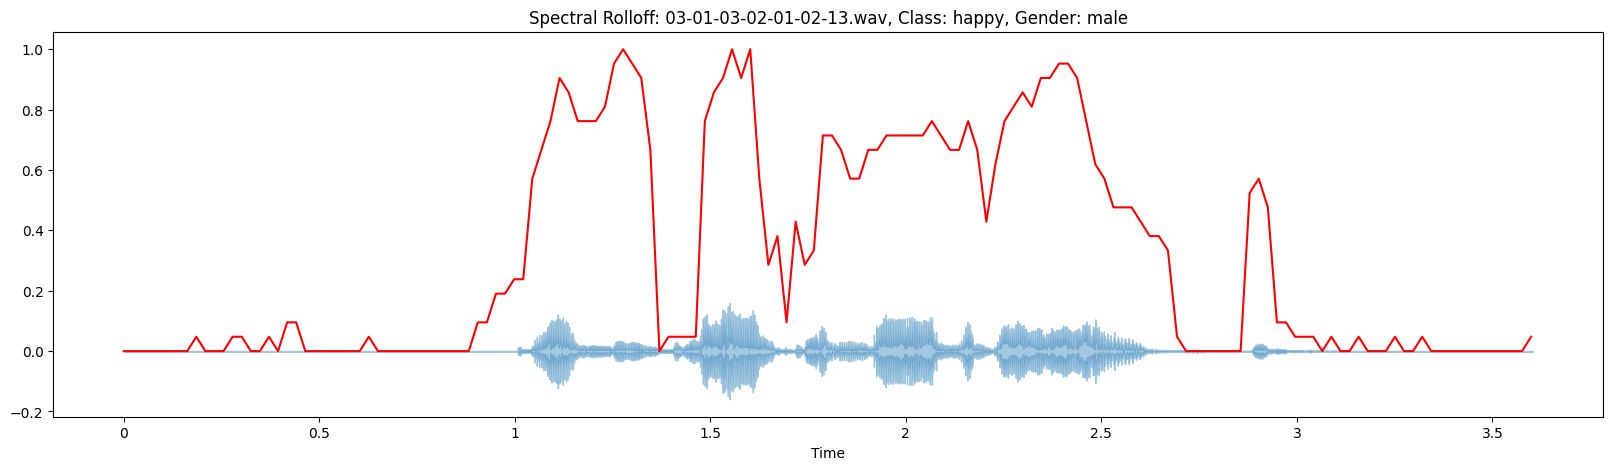

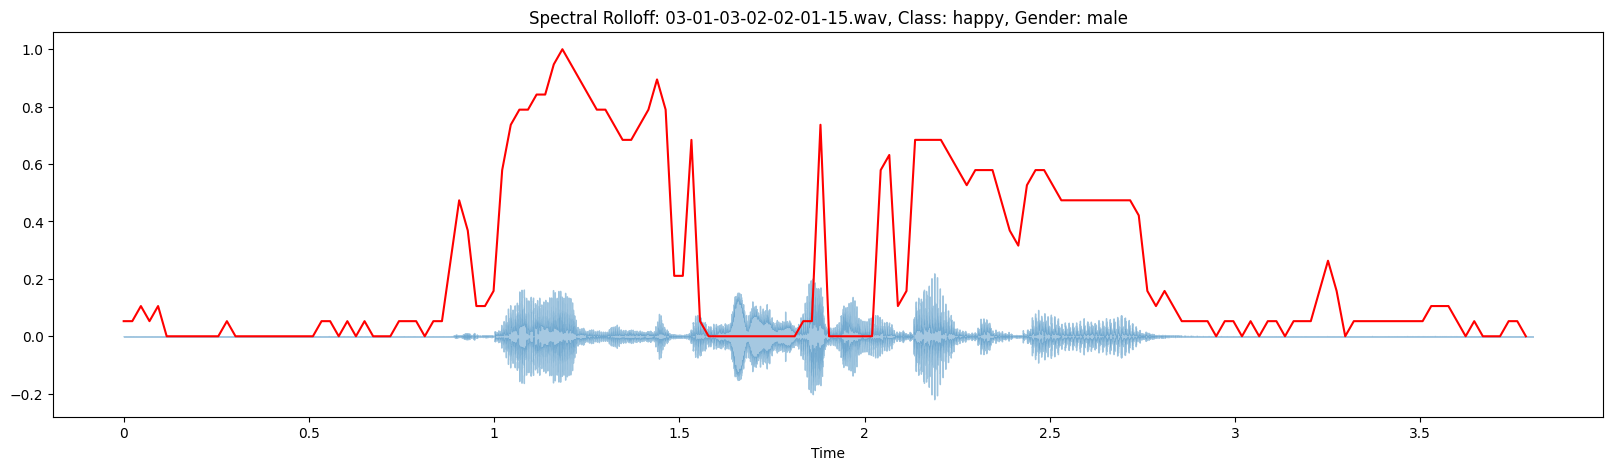

In [37]:
show_spectral_rolloff(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_spectral_rolloff(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_spectral_rolloff(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

## MFCC - HAPPY

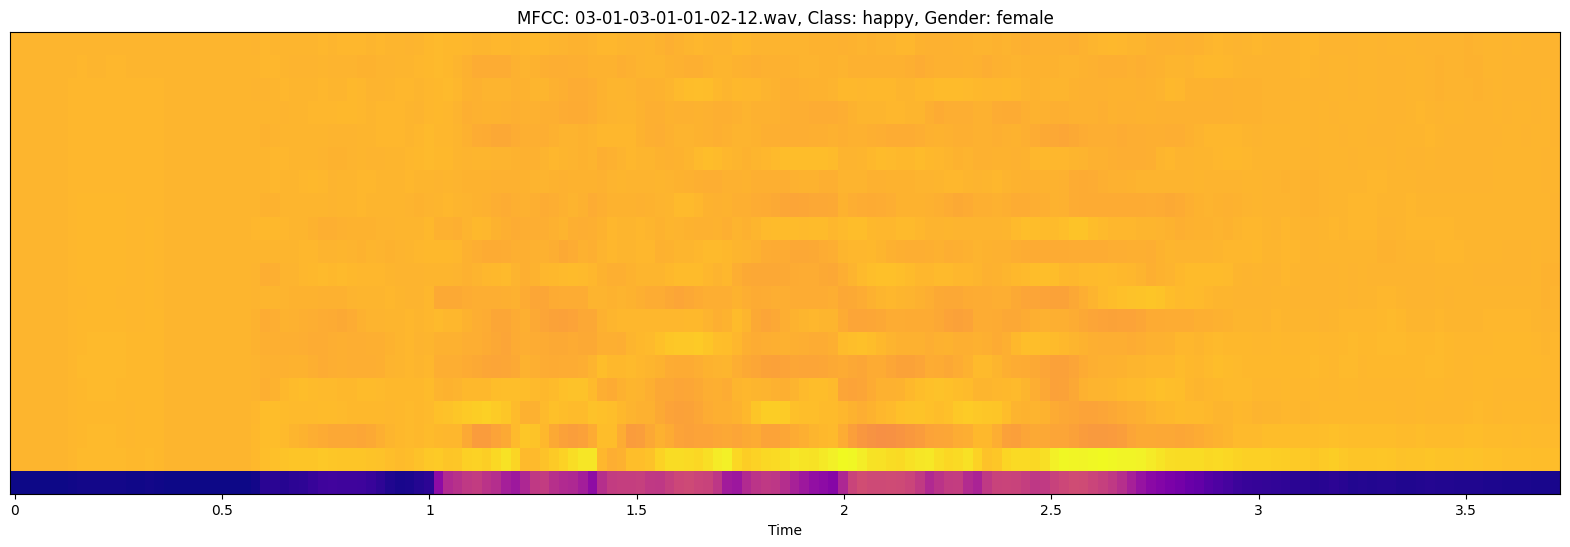

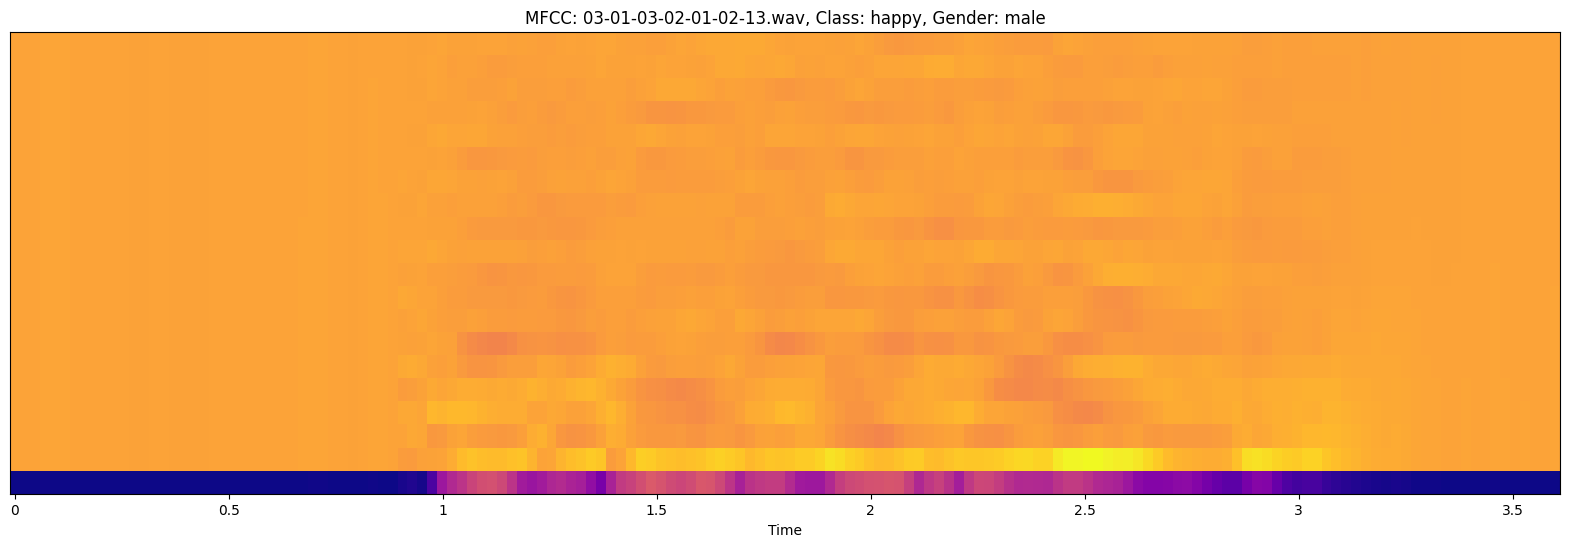

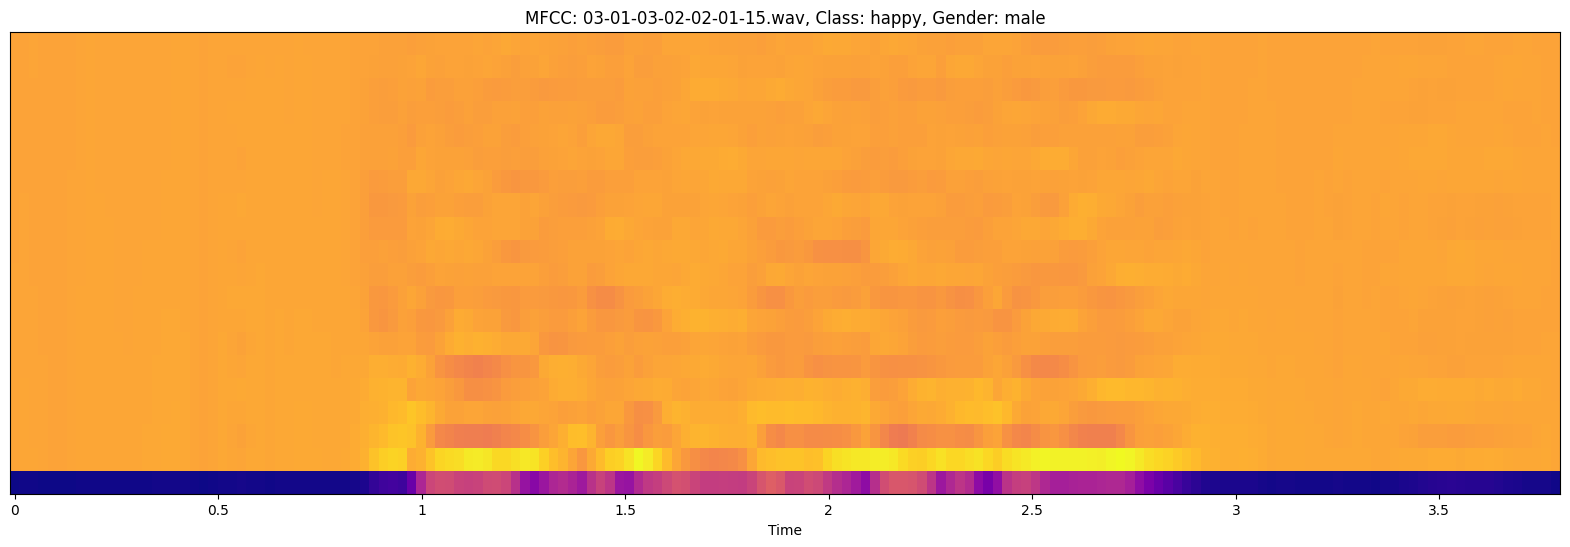

In [38]:
show_mfccs(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_mfccs(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_mfccs(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

## MFCC - SAD

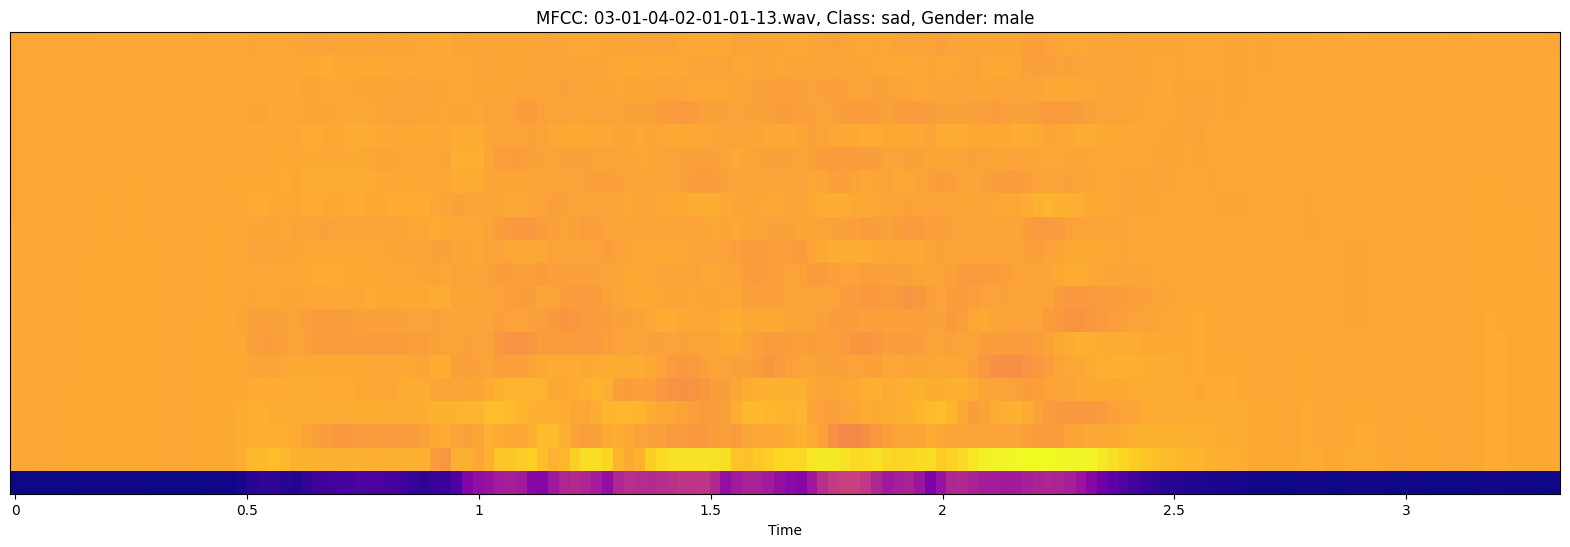

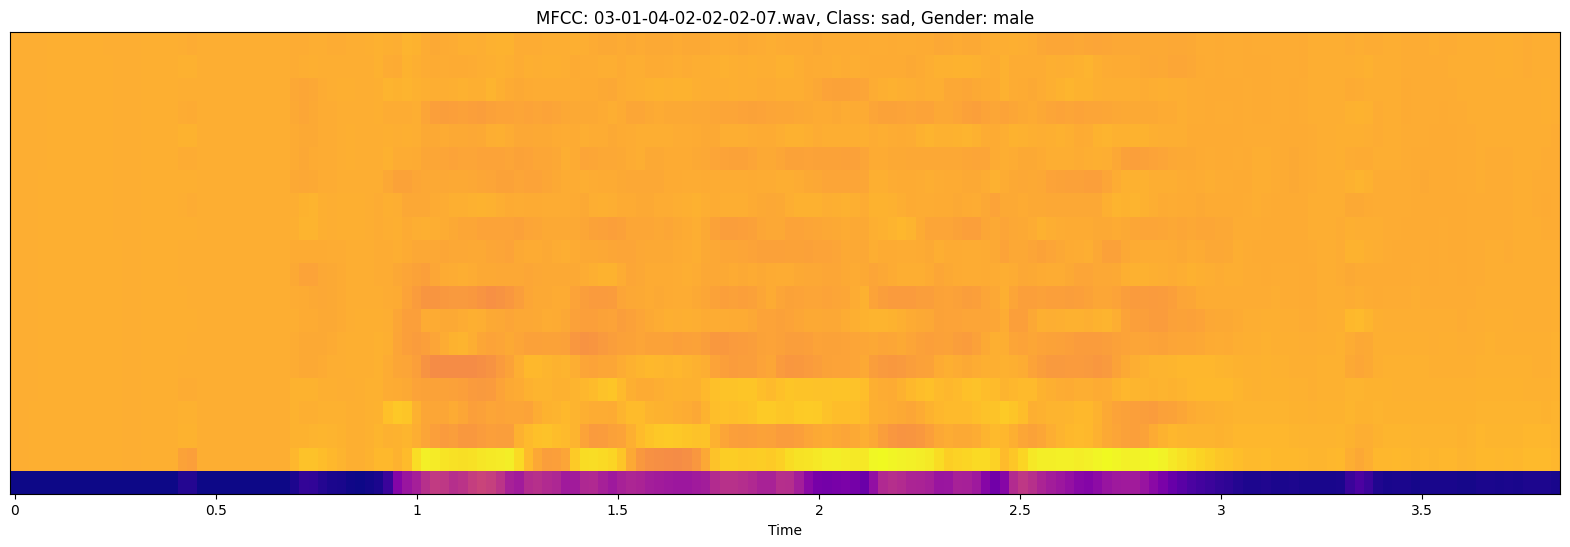

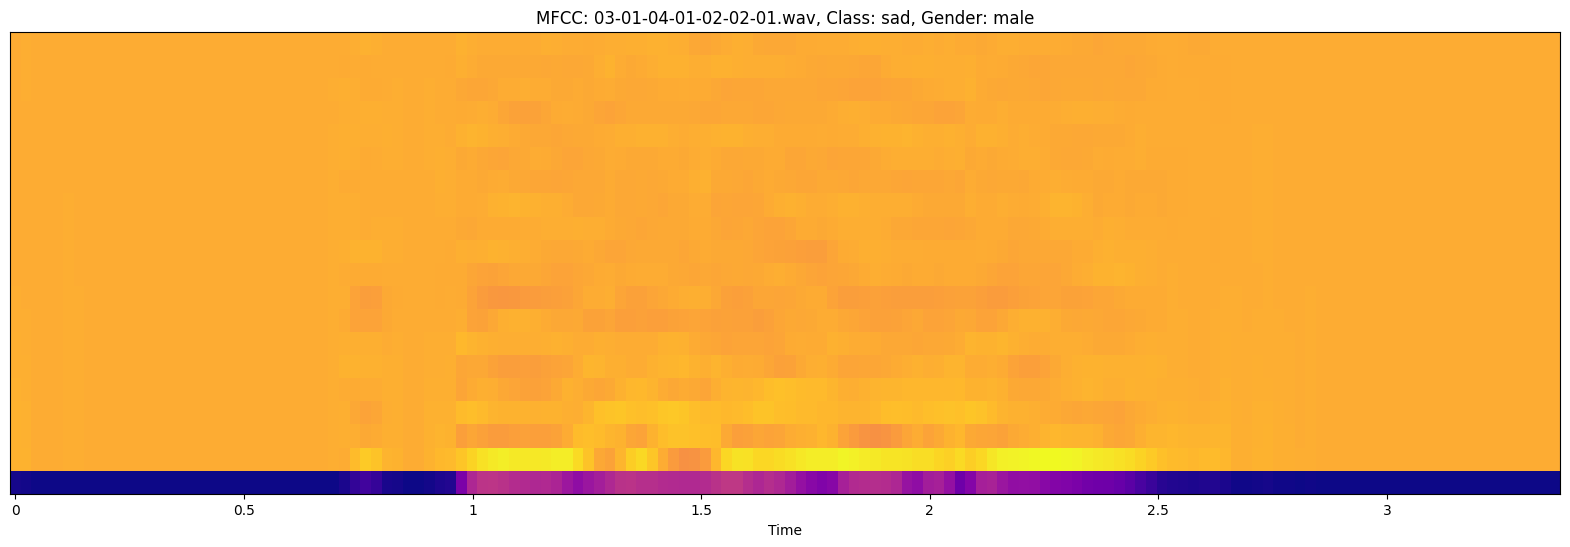

In [39]:
show_mfccs(sad.iloc[0].path,sad.iloc[0].filename,'sad',sad.iloc[0].gender)
show_mfccs(sad.iloc[1].path,sad.iloc[1].filename,'sad',sad.iloc[1].gender)
show_mfccs(sad.iloc[2].path,sad.iloc[2].filename,'sad',sad.iloc[2].gender)

# Modelling

In [40]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
def feature_extraction(df, mfcc=True):
    features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        x , sr = librosa.load(record['path'])
        mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=40),axis=1)
        mean_ms = np.mean(librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128),axis=1)
        features.append(mean_mfcc if mfcc else mean_ms)

    dataf = pd.DataFrame(features)
    dataf['class'] = df['class']
    return dataf

In [42]:
dataf = feature_extraction(data)
dataf

100%|██████████| 384/384 [04:15<00:00,  1.51it/s]


0          1          2          3         4          5  \
0   -635.302246  41.707790  -3.427747  -0.056352  1.938260  -2.269560   
1   -495.206818  33.357094 -21.610193  -7.654923 -5.631409 -12.533738   
2   -497.522675  35.862823 -14.676250  -4.995769 -1.377509 -10.426265   
3   -626.146179  47.941387  -9.495060   1.125753  2.470953  -6.917663   
4   -654.039246  50.435333  -4.741444   3.895281  5.399779  -6.449695   
..          ...        ...        ...        ...       ...        ...   
379 -620.267761  54.993256  -5.729505  13.725473  3.938453  -2.741892   
380 -699.104248  65.496918  -1.099551  16.531912  8.523048  -0.467124   
381 -711.786194  59.567207   0.710945  15.603702  6.023351  -0.162291   
382 -735.523987  60.409447  -3.443985  14.033259  6.590171  -1.768474   
383 -605.888977  50.817348  -4.100936  13.333531  2.314354  -3.124966   

             6          7          8         9  ...        31        32  \
0   -11.085616 -13.622803 -15.454366 -2.450259  ...  9.715651  8.712881   
1   -14.770957 -11.356813 -16.127691 -2.483285  ...  1.495526 -1.235061   
2   -15.622965 -12.209680 -14.318300 -3.152851  ...  1.182876 -0.972637   
3   -10.231542  -9.482229 -13.857183 -1.332145  ...  4.497144  3.165523   
4    -8.016534 -10.099738 -11.151771  0.242992  ...  0.805500 -0.108071   
..         ...        ...        ...       ...  ...       ...       ...   
379  -6.817740  -9.286635 -18.480106 -4.893465  ... -2.531231 -3.387981   
380   0.173822  -7.589049 -10.304403 -5.525469  ... -2.317086 -2.769871   
381   1.246117  -7.515767 -12.228474 -3.974104  ... -1.616274 -2.040626   
382  -1.731575  -7.569150 -10.976077 -3.822177  ... -3.586309 -1.806137   
383  -6.993569  -8.871110 -15.973222 -3.851796  ... -2.657781 -3.896538   

            33        34        35        36        37        38        39  \
0    10.796610  9.082943  7.943998  4.436741  3.421674 -1.604051  0.249133   
1     1.901431 -0.189306  3.644515  2.975521  1.868472 -1.103485  0.871370   
2    -0.394846 -2.452504  2.295696  2.915182  2.311038 -0.760128  1.790021   
3     4.343353  5.481231  7.904675  7.744648  7.101226  0.294467  0.279312   
4     1.208779  3.565412  3.319288  4.675538  6.427094  2.917819  6.547615   
..         ...       ...       ...       ...       ...       ...       ...   
379  -2.763266 -4.043507 -2.338431 -0.745812 -0.556042 -0.577349 -0.258658   
380  -2.094048 -4.340174 -0.674793 -2.137396 -2.431115 -3.649275 -2.926524   
381  -2.500549 -4.126199 -1.667965 -2.140113 -1.650078 -2.724934 -2.540101   
382  -1.401728 -3.150946 -0.854941 -0.846694 -2.121225 -4.232899 -2.810548   
383  -3.126862 -4.040146 -2.013698 -1.522867 -2.444298 -3.145026 -2.006853   

     class  
0      sad  
1    happy  
2    happy  
3      sad  
4      sad  
..     ...  
379    sad  
380    sad  
381    sad  
382    sad  
383    sad  

[384 rows x 41 columns]

In [43]:
X = dataf.iloc[:,:-1]
y = dataf.iloc[:,-1]

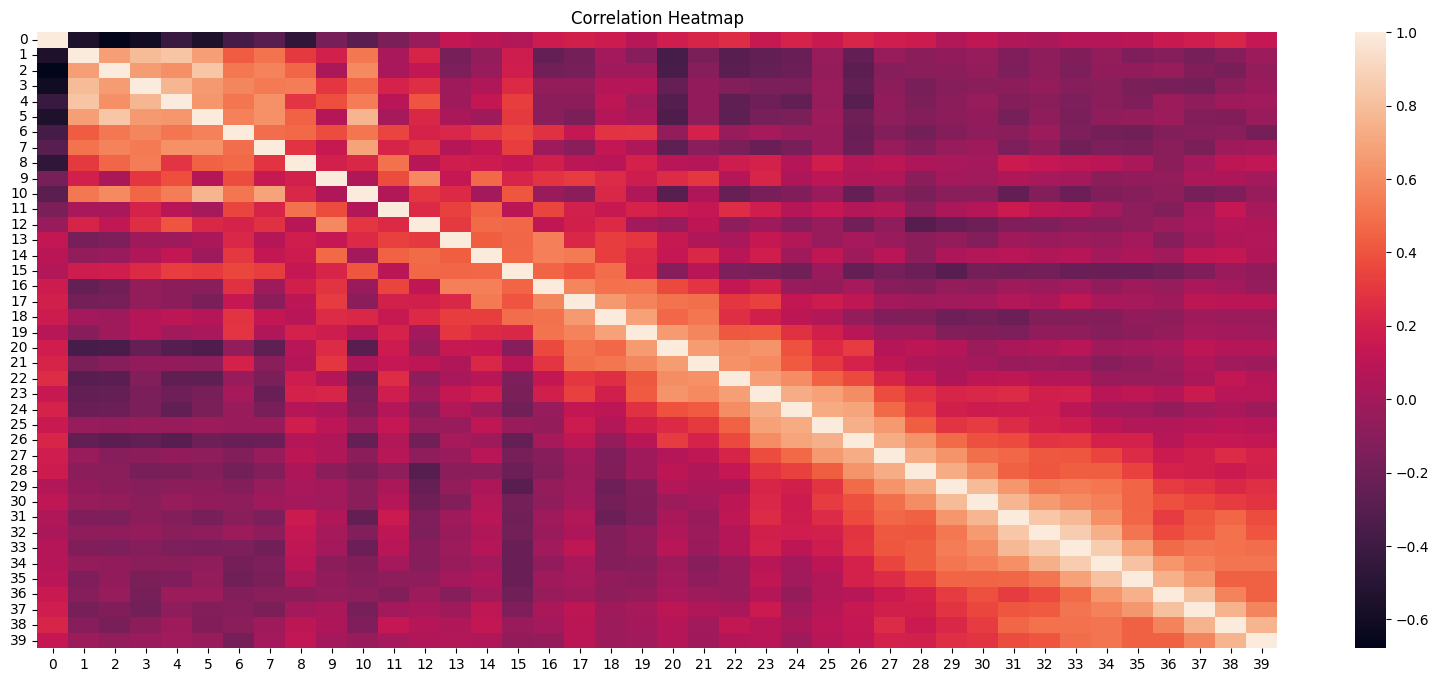

In [44]:
plt.figure(figsize=(20,8))
sns.heatmap(X.corr())
plt.title("Correlation Heatmap")
plt.show()

In [45]:
def LogisticRegressionPipeline(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    pipeline = Pipeline([('scaler',StandardScaler()),('LogisticRegression',LogisticRegression())])
    pipeline.fit(X_train,y_train)
    y_train_pred = pipeline.predict(X_train)
    y_pred = pipeline.predict(X_test)

    cmatrix = confusion_matrix(y_test,y_pred)

    print("Training Performance")
    print(classification_report(y_train,y_train_pred))
    print("-----------------------------------------")
    print("Test Performance")
    print(classification_report(y_test,y_pred))
    print("-----------------------------------------")

    cv_score = cross_val_score(pipeline,X,y,cv=5)
    average = lambda x: sum(x)/len(x)
    print("5-Folds Scores: ", cv_score)
    print("-----------------------------------------")
    print("5-Folds Average Score: ",average(cv_score))

    return cv_score, cmatrix

In [46]:
scores, cmatrix = LogisticRegressionPipeline(X,y)

Training Performance
              precision    recall  f1-score   support

       happy       0.85      0.84      0.85       153
         sad       0.85      0.85      0.85       154

    accuracy                           0.85       307
   macro avg       0.85      0.85      0.85       307
weighted avg       0.85      0.85      0.85       307

-----------------------------------------
Test Performance
              precision    recall  f1-score   support

       happy       0.86      0.77      0.81        39
         sad       0.79      0.87      0.82        38

    accuracy                           0.82        77
   macro avg       0.82      0.82      0.82        77
weighted avg       0.82      0.82      0.82        77

-----------------------------------------
5-Folds Scores:  [0.64935065 0.62337662 0.7012987  0.68831169 0.68421053]
-----------------------------------------
5-Folds Average Score:  0.6693096377306904


<Axes: >

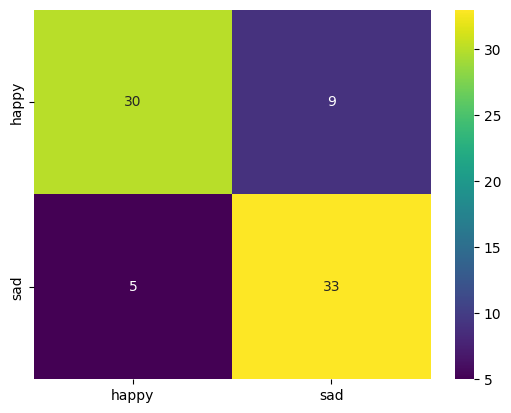

In [47]:
sns.heatmap(cmatrix,annot=True,fmt='.3g',cmap='viridis',xticklabels=['happy','sad'],yticklabels=['happy','sad'])

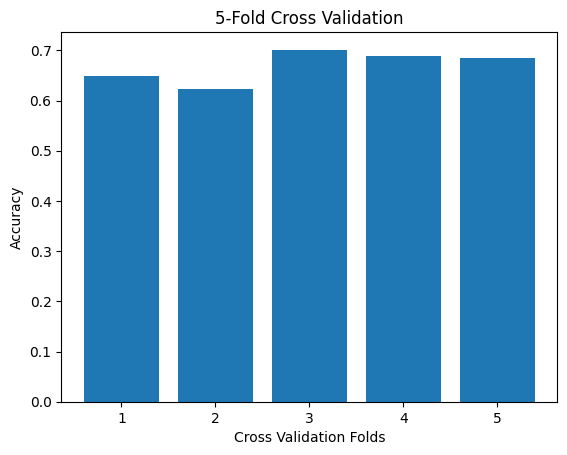

In [48]:
plt.bar(x=list(range(1,6)),height=scores)
plt.xlabel("Cross Validation Folds")
plt.ylabel("Accuracy")
plt.title("5-Fold Cross Validation")
plt.show()

## Mel Spectrogram features

In [49]:
dataf = feature_extraction(data,mfcc=False)
dataf

100%|██████████| 384/384 [00:17<00:00, 22.03it/s]


0         1         2         3         4         5         6  \
0    0.000002  0.000005  0.000007  0.000005  0.000021  0.001316  0.025991   
1    0.000003  0.000016  0.000070  0.000056  0.000043  0.002104  0.020278   
2    0.000033  0.000124  0.000328  0.000199  0.000090  0.005243  0.028909   
3    0.000004  0.000008  0.000011  0.000007  0.000056  0.003578  0.036559   
4    0.000003  0.000012  0.000016  0.000014  0.000118  0.010443  0.044104   
..        ...       ...       ...       ...       ...       ...       ...   
379  0.000001  0.000016  0.000328  0.010890  0.074086  0.124809  0.133636   
380  0.000007  0.000028  0.002289  0.021288  0.030576  0.005239  0.002685   
381  0.000002  0.000058  0.003313  0.022251  0.028204  0.008907  0.004497   
382  0.000001  0.000025  0.002010  0.014341  0.014445  0.001628  0.001802   
383  0.000008  0.000043  0.000411  0.015154  0.108379  0.137113  0.054111   

            7         8         9  ...       119       120       121  \
0    0.176738  0.130369  0.016669  ...  0.000352  0.000567  0.000199   
1    0.089653  0.235127  0.405127  ...  0.000214  0.000301  0.000381   
2    0.121992  0.187489  0.572866  ...  0.000404  0.000442  0.000488   
3    0.102822  0.107738  0.033627  ...  0.000047  0.000034  0.000024   
4    0.031716  0.025218  0.028095  ...  0.000121  0.000099  0.000050   
..        ...       ...       ...  ...       ...       ...       ...   
379  0.016080  0.018265  0.052385  ...  0.000057  0.000071  0.000041   
380  0.023043  0.029120  0.026502  ...  0.000007  0.000005  0.000005   
381  0.022068  0.029430  0.021489  ...  0.000031  0.000014  0.000009   
382  0.017606  0.022957  0.012038  ...  0.000008  0.000009  0.000009   
383  0.012544  0.028197  0.142064  ...  0.000080  0.000076  0.000062   

          122       123       124       125       126           127  class  
0    0.000115  0.000107  0.000130  0.000116  0.000096  1.360968e-05    sad  
1    0.000441  0.000535  0.000623  0.000460  0.000218  1.539581e-05  happy  
2    0.000514  0.000702  0.001001  0.000747  0.000470  4.293247e-05  happy  
3    0.000020  0.000018  0.000028  0.000032  0.000014  1.073783e-06    sad  
4    0.000049  0.000066  0.000067  0.000061  0.000033  2.456439e-06    sad  
..        ...       ...       ...       ...       ...           ...    ...  
379  0.000035  0.000040  0.000065  0.000077  0.000045  3.697519e-06    sad  
380  0.000007  0.000007  0.000009  0.000010  0.000005  5.536571e-07    sad  
381  0.000012  0.000020  0.000035  0.000050  0.000043  5.104456e-06    sad  
382  0.000007  0.000006  0.000007  0.000009  0.000008  7.576907e-07    sad  
383  0.000059  0.000088  0.000164  0.000201  0.000093  7.595863e-06    sad  

[384 rows x 129 columns]

In [50]:
X = dataf.iloc[:,:-1]
y = dataf.iloc[:,-1]

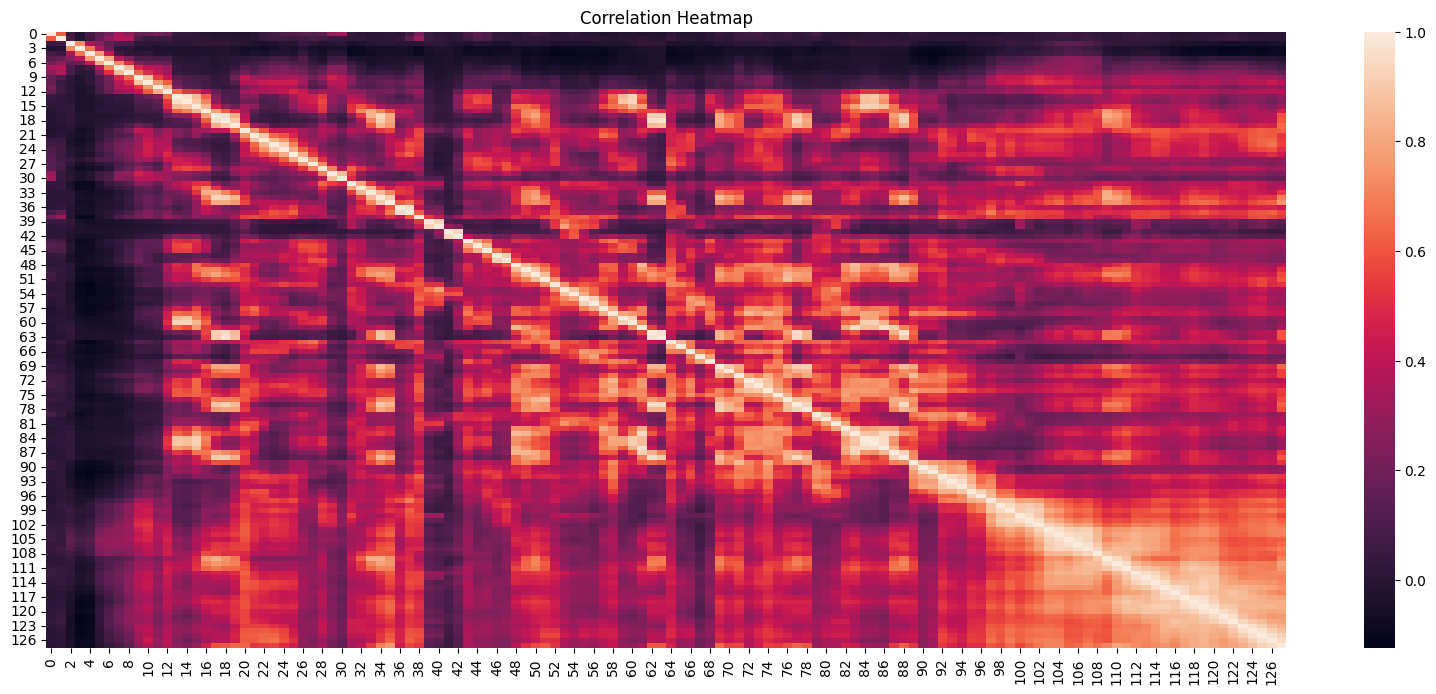

In [51]:
plt.figure(figsize=(20,8))
sns.heatmap(X.corr())
plt.title("Correlation Heatmap")
plt.show()

## Feature Scale

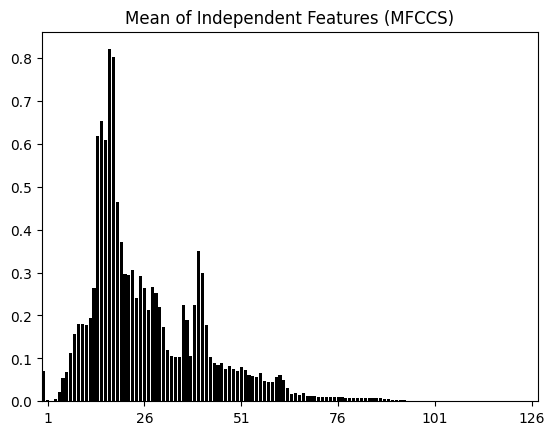

In [52]:
sns.barplot(x=X.columns,y=X.mean(axis=0),color='black')
plt.title("Mean of Independent Features (MFCCS)")
plt.xticks(ticks=list(range(1,129,25)))
plt.show()

In [53]:
scores, cmatrix = LogisticRegressionPipeline(X,y)

Training Performance
              precision    recall  f1-score   support

       happy       0.92      0.70      0.80       153
         sad       0.76      0.94      0.84       154

    accuracy                           0.82       307
   macro avg       0.84      0.82      0.82       307
weighted avg       0.84      0.82      0.82       307

-----------------------------------------
Test Performance
              precision    recall  f1-score   support

       happy       0.83      0.49      0.61        39
         sad       0.63      0.89      0.74        38

    accuracy                           0.69        77
   macro avg       0.73      0.69      0.68        77
weighted avg       0.73      0.69      0.68        77

-----------------------------------------
5-Folds Scores:  [0.61038961 0.66233766 0.63636364 0.7012987  0.69736842]
-----------------------------------------
5-Folds Average Score:  0.6615516062884483


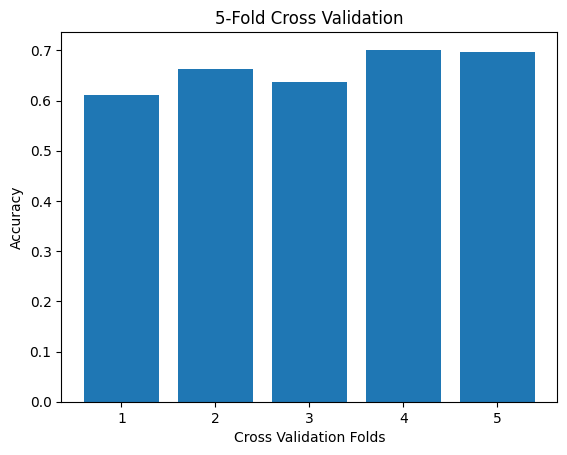

In [54]:
plt.bar(x=list(range(1,6)),height=scores)
plt.xlabel("Cross Validation Folds")
plt.ylabel("Accuracy")
plt.title("5-Fold Cross Validation")
plt.show()